In [1]:
import autoroot
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jaxtyping import (
    Array,
    Float,
)
import matplotlib.pyplot as plt
import numpy as np

from somax.masks import MaskGrid
from somax.interp import center_avg_2D
from somax._src.operators.differential import difference
from loguru import logger

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# set parameters
logger.info("Starting script...")

2024-06-17 11:15:10.923 | INFO     | __main__:<module>:2 - Starting script...


In [3]:
logger.info("Setting Parameters...")
n_x = 100
dx = 20e3

n_y = 101
dy = 20e3

gravity = 9.81
depth = 100.0
coriolis_param = 2e-4

dt = 0.5 * min(dx, dy) / np.sqrt(gravity * depth)

phase_speed = np.sqrt(gravity * depth)
rossby_radius = np.sqrt(gravity * depth) / coriolis_param

2024-06-17 11:15:11.102 | INFO     | __main__:<module>:1 - Setting Parameters...


In [4]:
# plot parameters
plot_range = 0.5
plot_every = 2
max_quivers = 21

# grid setup
x, y = (np.arange(n_x) * dx, np.arange(n_y) * dy)
X, Y = np.meshgrid(x, y, indexing="ij")

# initial conditions
h0 = depth + 1.0 * np.exp(
    -((X - x[n_x // 2]) ** 2) / rossby_radius**2
    - (Y - y[n_y - 2]) ** 2 / rossby_radius**2
)

# mask
mask = jnp.ones_like(X)
mask = mask.at[-1].set(0.0)
mask = mask.at[:, 0].set(0.0)
mask = mask.at[:, -1].set(0.0)
masks = MaskGrid.init_mask(mask, "center")


In [10]:
u0 = np.zeros_like(masks.face_u.values)
v0 = np.zeros_like(masks.face_v.values)

print(u0.shape, v0.shape, h0.shape)


def prepare_plot():
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    cs = update_plot(0, h0, u0, v0, ax)
    plt.colorbar(cs, label="$\\eta$ (m)")
    plt.show()
    return fig, ax

(101, 101) (100, 102) (100, 101)


In [11]:

def update_plot(t, h, u, v, ax):
    eta = h - depth

    quiver_stride = (slice(1, -1, n_x // max_quivers), slice(1, -1, n_y // max_quivers))

    ax.clear()
    cs = ax.pcolormesh(
        x[1:-1] / 1e3,
        y[1:-1] / 1e3,
        eta[1:-1, 1:-1].T,
        vmin=-plot_range,
        vmax=plot_range,
        cmap="RdBu_r",
    )

    if np.any((u[quiver_stride] != 0) | (v[quiver_stride] != 0)):
        ax.quiver(
            x[quiver_stride[0]] / 1e3,
            y[quiver_stride[1]] / 1e3,
            u[quiver_stride].T,
            v[quiver_stride].T,
            clip_on=False,
        )

    ax.set_aspect("equal")
    ax.set_xlabel("$x$ (km)")
    ax.set_ylabel("$y$ (km)")
    ax.set_xlim(x[1] / 1e3, x[-2] / 1e3)
    ax.set_ylim(y[1] / 1e3, y[-2] / 1e3)
    ax.set_title(
        "t=%5.2f days, R=%5.1f km, c=%5.1f m/s "
        % (t / 86400, rossby_radius / 1e3, phase_speed)
    )
    plt.pause(0.1)
    plt.show()
    return cs

In [12]:
def enforce_boundaries(u, variable: str = "h"):
    if variable == "h":
        pass
    elif variable == "u":
        u = u.at[-2].set(0.0)
    elif variable == "v":
        u = u.at[:, -2].set(0.0)
    else:
        msg = "Unrecognized variable"
        raise ValueError(msg)
    return u

In [13]:
def iterate_shallow_water():
    # allocate arrays
    u, v, h = jnp.empty_like(u0), jnp.empty_like(v0), jnp.empty_like(h0)

    # initial conditions
    h: Float[Array, "Nx Ny"] = h.at[:].set(h0)
    u: Float[Array, "Nx+1 Ny"] = u.at[:].set(u0)
    v: Float[Array, "Nx Ny+1"] = v.at[:].set(v0)

    # apply masks
    h *= masks.center.values
    u *= masks.face_u.values
    v *= masks.face_v.values

    def equation_of_motion(h, u, v):
        # ================================
        # update zonal velocity, u
        # ================================
        v_avg: Float[Array, "Nx-1 Ny"] = center_avg_2D(v)
        dh_dx: Float[Array, "Nx-1 Ny"] = difference(
            h, step_size=dx, axis=0, derivative=1
        )

        u_rhs: Float[Array, "Nx-1 Ny"] = coriolis_param * v_avg - gravity * dh_dx

        # apply masks
        u_rhs *= masks.face_u.values[1:-1]

        # time step u
        u: Float[Array, "Nx+1 Ny"] = u.at[1:-1].add(dt * u_rhs)

        u = enforce_boundaries(u, "u")

        # =================================
        # update meridional velocity, v
        # =================================
        u_avg: Float[Array, "Nx Ny-1"] = center_avg_2D(u)
        dh_dy: Float[Array, "Nx Ny-1"] = difference(
            h, step_size=dy, axis=1, derivative=1
        )

        v_rhs: Float[Array, "Nx Ny-1"] = -coriolis_param * u_avg - gravity * dh_dy

        # apply masks
        v_rhs *= masks.face_v.values[:, 1:-1]

        # time step v
        v: Float[Array, "Nx Ny+1"] = v.at[:, 1:-1].add(dt * v_rhs)

        v = enforce_boundaries(v, "v")

        # =================================
        # update height, h
        # =================================
        du_dx: Float[Array, "Nx Ny"] = difference(u, step_size=dx, axis=0, derivative=1)
        dv_dy: Float[Array, "Nx Ny"] = difference(v, step_size=dy, axis=1, derivative=1)

        h_rhs: Float[Array, "Nx Ny"] = -depth * (du_dx + dv_dy)

        # apply masks
        h_rhs *= masks.center.values

        # time step h
        h: Float[Array, "Nx Ny"] = h.at[:].add(dt * h_rhs)

        h = enforce_boundaries(h, "h")

        return h, u, v

    eom_fn = jax.jit(equation_of_motion)

    # time step equations
    while True:
        h, u, v = eom_fn(h, u, v)

        yield h, u, v


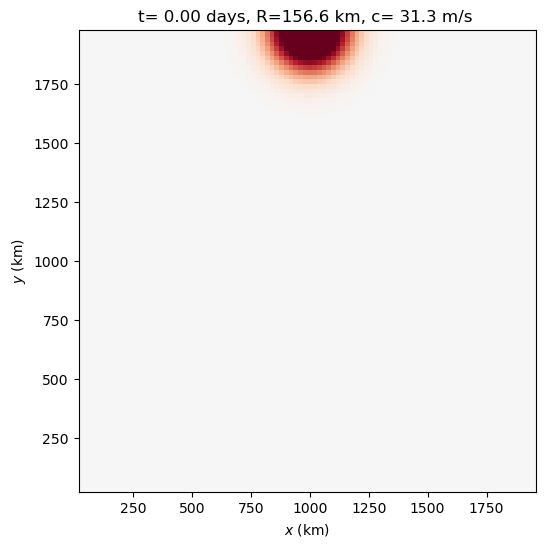

<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

In [14]:
fig, ax = prepare_plot()

# create model generator
model = iterate_shallow_water()

# iterate through steps
for iteration, (h, u, v) in enumerate(model):
    if iteration % plot_every == 0:
        t = iteration * dt

        # move face variables to center
        # u,v --> h
        u_on_h = center_avg_2D(u)
        v_on_h = center_avg_2D(v)

        # update plot
        update_plot(t, h, u_on_h, v_on_h, ax)

    # # stop if user closes plot window
    # if not plt.fignum_exists(fig.number):
    #     break